# Gosoft Data Scientist Assesment
## Demand Forecasting

by Tanat Metmaolee

__Goal__: To predict 3 months of item-level sales data at different store locations

## Understand the Objective
1. The Dataset is considered a [Time Series Analysis](https://www.tableau.com/analytics/what-is-time-series-analysis)
2. To create/choose an optimal statistics/machine learning model to predict item-level sales in advance.
3. Evaluate and Propose how to deal with future demanding forecast to improve profit margins.

### Curiousity
1. item-level sales data at different stores = each item in each store prediction?
2. ARIMA, Prophet (Univariate), Vector Autoregression (Multivariate) Model?
3. Is there any packages you require me to use, or any packages that can't be used?
4. Or any suggestions?
5. Planning to finish the tasks with this weekend, how long would the review takes? 

### Answers from the recruiter
1. Yes
2. Didn't ask but they should be included
3. Any packages are OK
4. Try to compare a lot of models
5. Take your time, it should take 1-2 days

### Packages

In [2]:
# Data Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score

## Data Collection

In [3]:
raw_df = pd.read_csv('demand-forecasting/train.csv')

In [4]:
test_df = pd.read_csv('demand-forecasting/test.csv')

## Data Preprocessing/Cleaning

### Dataset Structure

In [5]:
# Preview
raw_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
test_df.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


### Null/Na values check

In [8]:
raw_df.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [9]:
raw_df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

### Unique Values

In [10]:
raw_df['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [11]:
raw_df['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

### Noise

### Anomaly Detection (Outliers)

Things that might need to be checked
- Z-Score
- Interquartile

#### IQR

In [14]:
q1 = raw_df['sales'].quantile(0.25)
q3 = raw_df['sales'].quantile(0.75)
iqr = q3 - q1

outliers = raw_df[(raw_df['sales'] < (q1 - 1.5 * iqr)) | (raw_df['sales'] > (q3 + 1.5 * iqr))]

outliers.shape

(11967, 4)

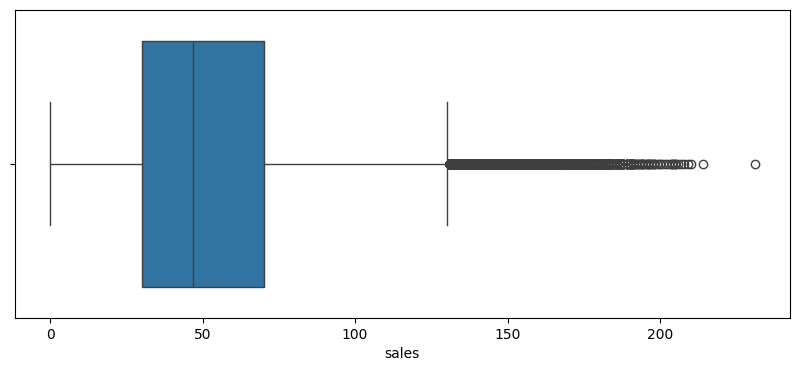

In [41]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=raw_df['sales'])
plt.show()

#### Z-Score

$ z = \frac{(x - \mu)}{\sigma} $

- z = Z-score
- x = the current value
- $\mu$ = mean
- $\sigma$ = SD

In [13]:
z_threshold = 3
data = raw_df['sales']
mean = np.mean(data)
sd = np.std(data)

### Data Conclusion

`store`, `item` Features are quite clean since they're discrete. 

`sales` Label is seemed to be preprocessed already too.

Therefore, we only need to fix `date` Feature.

### `date` feature format approach

1. Store each store's product in Python dictionary
2. Use in-built pandas Method -> `pd.to_datetime()` then add new columns as `day` `Month` `Year`

In [15]:
df = raw_df
df['date'] = pd.to_datetime(df['date'])

We're going to keep the `date` column for the future insight uses

In [16]:
df['day_of_week'] = df['date'].dt.day_of_week
df['day_of_month'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

#### Dictionary Approach (Not Dynamic)

In [17]:
def store_split(df) -> dict:
    store_len = len(df['store'].unique())
    item_len = len(df['item'].unique())
    store = {}
    for i in range(1, store_len + 1):
        store[i] = {}
        for j in range(1, item_len + 1):
            store[i][j] = df[(df['store'] == i) & (df['item'] == j)]
    return store

In [18]:
stores = store_split(df)

Now we can access each store's product with `stores[store_number][item_number]`

In [19]:
stores[10][1].head()

,date,store,item,sales,day_of_week,day_of_month,month,year
16434,2013-01-01,10,1,14,1,1,1,2013
16435,2013-01-02,10,1,14,2,2,1,2013
16436,2013-01-03,10,1,16,3,3,1,2013
16437,2013-01-04,10,1,17,4,4,1,2013
16438,2013-01-05,10,1,12,5,5,1,2013


In [20]:
len(stores[10][10])

1826

The problem with this approach is:
1. The function is hard to maintain when there is a change in data.
2. Drill Down can only be use in item-level in each stores but not store-level.
3. Less Optimized than another approach (Both Time and Space).

#### In-Built pandas Approach (Preferred)

In [21]:
# Store-Level Drill Down Test
df[df['store'] == 1]

,date,store,item,sales,day_of_week,day_of_month,month,year
0,2013-01-01,1,1,13,1,1,1,2013
1,2013-01-02,1,1,11,2,2,1,2013
2,2013-01-03,1,1,14,3,3,1,2013
3,2013-01-04,1,1,13,4,4,1,2013
4,2013-01-05,1,1,10,5,5,1,2013
...,...,...,...,...,...,...,...,...
896561,2017-12-27,1,50,38,2,27,12,2017
896562,2017-12-28,1,50,52,3,28,12,2017
896563,2017-12-29,1,50,59,4,29,12,2017
896564,2017-12-30,1,50,66,5,30,12,2017


In [22]:
# Item-Level Drill Down Test
df[(df['store'] == 1) & (df['item'] == 2)]

,date,store,item,sales,day_of_week,day_of_month,month,year
18260,2013-01-01,1,2,33,1,1,1,2013
18261,2013-01-02,1,2,43,2,2,1,2013
18262,2013-01-03,1,2,23,3,3,1,2013
18263,2013-01-04,1,2,18,4,4,1,2013
18264,2013-01-05,1,2,34,5,5,1,2013
...,...,...,...,...,...,...,...,...
20081,2017-12-27,1,2,55,2,27,12,2017
20082,2017-12-28,1,2,50,3,28,12,2017
20083,2017-12-29,1,2,50,4,29,12,2017
20084,2017-12-30,1,2,56,5,30,12,2017


### Time-step Features

Time-Step Features might not be necessary in this assessment.

### Lag Features
This is added specifically for Time Series Analysis uses

In [23]:
for i in (1, 7, 30):
    df[f'lag_{i}'] = df.groupby(['store', 'item'])['sales'].shift(i)

# df.set_index(['date', 'store', 'item', 'sales', 'lag_1', 'lag_7', 'lag_30', 'day_of_week', 'day_of_month', 'year'])

In [24]:
df[(df['store'] == 1) & (df['item'] == 1)].head(31)

,date,store,item,sales,day_of_week,day_of_month,month,year,lag_1,lag_7,lag_30
0,2013-01-01,1,1,13,1,1,1,2013,NaN,NaN,NaN
1,2013-01-02,1,1,11,2,2,1,2013,13.0,NaN,NaN
2,2013-01-03,1,1,14,3,3,1,2013,11.0,NaN,NaN
3,2013-01-04,1,1,13,4,4,1,2013,14.0,NaN,NaN
4,2013-01-05,1,1,10,5,5,1,2013,13.0,NaN,NaN
5,2013-01-06,1,1,12,6,6,1,2013,10.0,NaN,NaN
6,2013-01-07,1,1,10,0,7,1,2013,12.0,NaN,NaN
7,2013-01-08,1,1,9,1,8,1,2013,10.0,13.0,NaN
8,2013-01-09,1,1,12,2,9,1,2013,9.0,11.0,NaN
9,2013-01-10,1,1,9,3,10,1,2013,12.0,14.0,NaN


## Exploratory Data Analysis (EDA)

In [25]:
df.describe()

,date,store,item,sales,day_of_week,day_of_month,month,year,lag_1,lag_7,lag_30
count,913000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000,912500.000000,909500.00000,898000.000000
mean,2015-07-02 11:59:59.999999744,5.500000,25.500000,52.250287,3.001643,15.727820,6.523549,2015.000548,52.249964,52.28043,52.375058
min,2013-01-01 00:00:00,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2013.000000,0.000000,0.00000,0.000000
25%,2014-04-02 00:00:00,3.000000,13.000000,30.000000,1.000000,8.000000,4.000000,2014.000000,30.000000,30.00000,30.000000
50%,2015-07-02 12:00:00,5.500000,25.500000,47.000000,3.000000,16.000000,7.000000,2015.000000,47.000000,47.00000,47.000000
75%,2016-10-01 00:00:00,8.000000,38.000000,70.000000,5.000000,23.000000,10.000000,2016.000000,70.000000,70.00000,70.000000
max,2017-12-31 00:00:00,10.000000,50.000000,231.000000,6.000000,31.000000,12.000000,2017.000000,231.000000,231.00000,231.000000
std,NaN,2.872283,14.430878,28.801144,1.999316,8.799329,3.448535,1.414021,28.802821,28.81846,28.876637


1. Data consist of 10 stores, 50 unique items
2. The Data was collected from Jan-2013 to Dec-2017
3. Total days of data is 1826 days, or about full 5 years

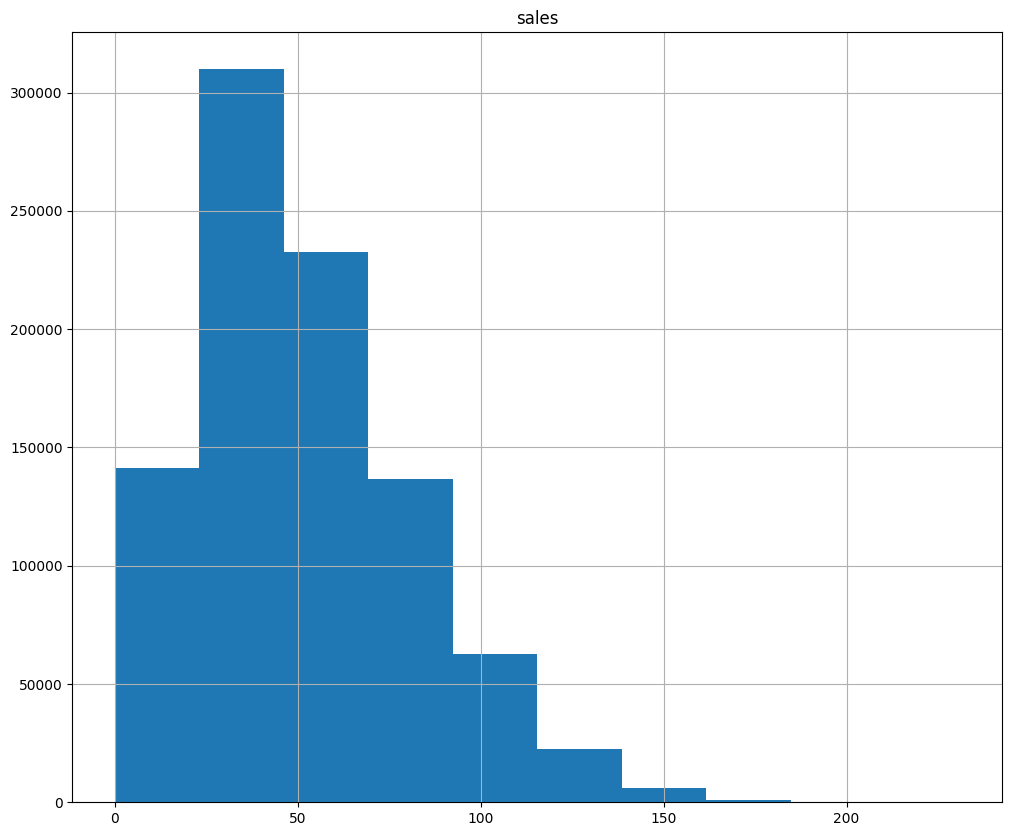

In [26]:
df.hist(column=['sales'], figsize=(12, 10))
plt.show()

### Correlation


#### Factors that might affect the sales
1. The location of the store
2. Difference items in each store has different sales value depending on each seasons
3. The date (Promotion Day, Season Sales Day, Weekday, Weekend, Season Demanding)


In [27]:
correlation_matrix = df.corr()

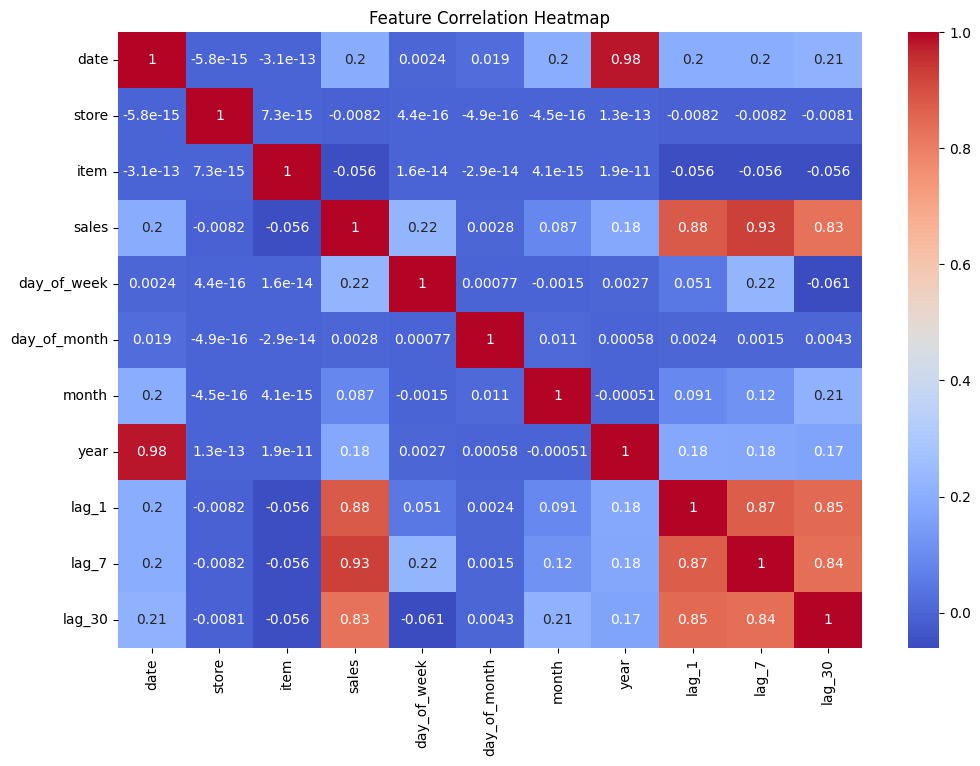

In [28]:
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [29]:
# sns.pairplot(df.drop(['date'], axis=1))
# plt.show()

In [30]:
store_number = 2    # From 1 to 10

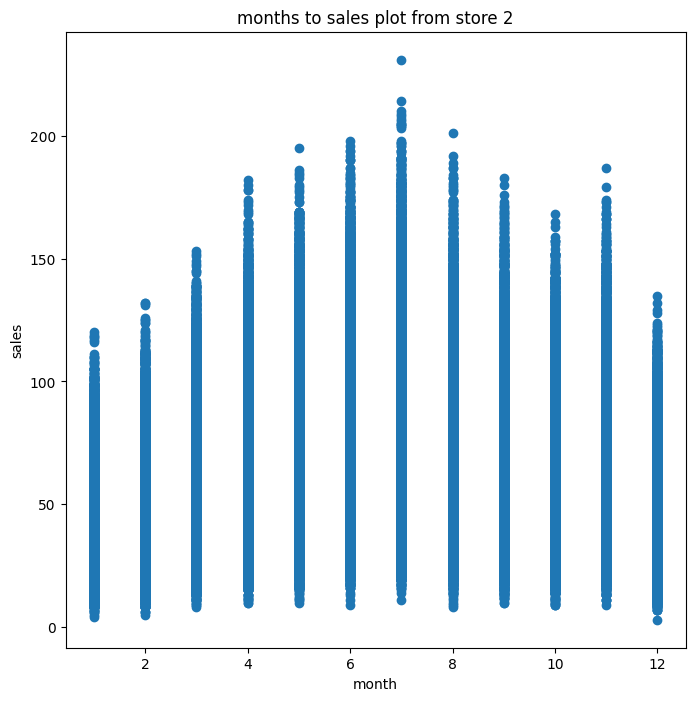

In [31]:
plt.figure(figsize=(8, 8))
plt.scatter(df[df['store'] == store_number].month, df[df['store'] == store_number].sales)
plt.title(f'months to sales plot from store {store_number}')
plt.xlabel('month')
plt.ylabel('sales')
plt.show()

### Sales Distribution

<Figure size 1000x800 with 0 Axes>

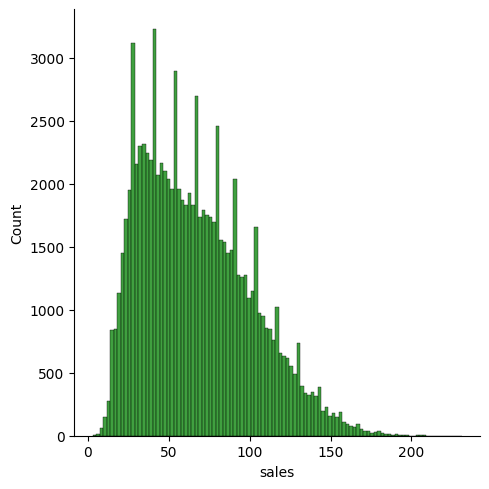

In [32]:
plt.figure(figsize=(10,8))
sns.displot(df[df['store'] == store_number].sales, color='green')
plt.show()

## Model Building

- Traditional Stats
    1. ARIMA
    2. SARIMAX
    3. Prophet
    4. Neural Prophet
- ML
    1. NNR
    2. Catboost
    3. Any Regressor

In [33]:
epochs = 1000
learning_rate = 0.01

In [34]:
X = df.drop(['sales'], axis=1)
y = df['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

### Training

In [35]:
xgb_model = XGBRegressor(n_estimators=epochs, learning_rate= learning_rate)

### Testing

### Cost Functions

## Deployment